<a href="https://colab.research.google.com/github/KirillShulepov/AIlabs/blob/main/laba4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Лабораторная работа №4 ФИО: Шулепов Кирилл Александрович Группа: БИВТ-22-СП-4

Пропуски в X_train: 0
Пропуски в X_test: 0
Epoch 1/10, Train Loss: 0.9533, Test Loss: 0.8178
Epoch 2/10, Train Loss: 0.7502, Test Loss: 0.7263
Epoch 3/10, Train Loss: 0.6856, Test Loss: 0.6876
Epoch 4/10, Train Loss: 0.6533, Test Loss: 0.6670
Epoch 5/10, Train Loss: 0.6342, Test Loss: 0.6546
Epoch 6/10, Train Loss: 0.6218, Test Loss: 0.6457
Epoch 7/10, Train Loss: 0.6114, Test Loss: 0.6405
Epoch 8/10, Train Loss: 0.6046, Test Loss: 0.6364
Epoch 9/10, Train Loss: 0.5978, Test Loss: 0.6323
Epoch 10/10, Train Loss: 0.5942, Test Loss: 0.6299


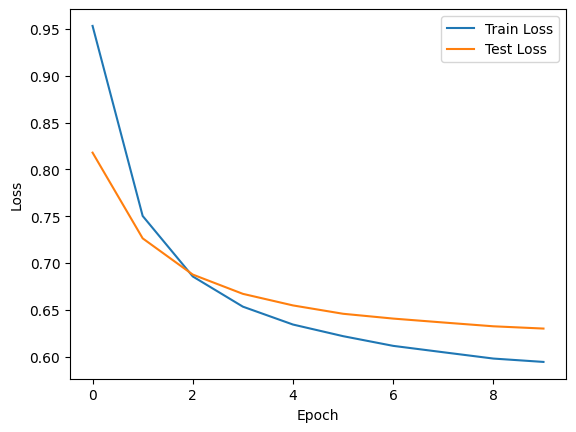

Train Accuracy: 0.7573, Test Accuracy: 0.7412


In [7]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.preprocessing import LabelEncoder
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

# Загрузка данных
data = pd.read_csv('dataset.csv')

# Разделение на признаки и целевую переменную
X = data.drop('Target', axis=1)
y = data['Target']

# Разделение на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Проверка на наличие пропусков
print("Пропуски в X_train:", X_train.isnull().sum().sum())
print("Пропуски в X_test:", X_test.isnull().sum().sum())

# Заполнение пропусков для числовых и категориальных переменных
numeric_imputer = SimpleImputer(strategy='mean')
categorical_imputer = SimpleImputer(strategy='most_frequent')

# Применение imputer к числовым признакам
X_train_numeric = numeric_imputer.fit_transform(X_train.select_dtypes(include=['float64', 'int64']))
X_test_numeric = numeric_imputer.transform(X_test.select_dtypes(include=['float64', 'int64']))

# Применение imputer к категориальным признакам, если они есть
if X_train.select_dtypes(include=['object']).shape[1] > 0:
    X_train_categorical = categorical_imputer.fit_transform(X_train.select_dtypes(include=['object']))
    X_test_categorical = categorical_imputer.transform(X_test.select_dtypes(include=['object']))

    # Объединение числовых и категориальных признаков
    X_train = pd.concat([pd.DataFrame(X_train_numeric, columns=X_train.select_dtypes(include=['float64', 'int64']).columns),
                         pd.DataFrame(X_train_categorical, columns=X_train.select_dtypes(include=['object']).columns)], axis=1)

    X_test = pd.concat([pd.DataFrame(X_test_numeric, columns=X_test.select_dtypes(include=['float64', 'int64']).columns),
                        pd.DataFrame(X_test_categorical, columns=X_test.select_dtypes(include=['object']).columns)], axis=1)
else:
    # Если категориальных признаков нет, просто используем числовые
    X_train = pd.DataFrame(X_train_numeric, columns=X_train.select_dtypes(include=['float64', 'int64']).columns)
    X_test = pd.DataFrame(X_test_numeric, columns=X_test.select_dtypes(include=['float64', 'int64']).columns)

# Нормализация числовых переменных
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.select_dtypes(include=['float64', 'int64']))
X_test_scaled = scaler.transform(X_test.select_dtypes(include=['float64', 'int64']))

# Объединение нормализованных числовых признаков с категориальными, если они есть
if X_train.select_dtypes(include=['object']).shape[1] > 0:
    X_train = pd.concat([pd.DataFrame(X_train_scaled, columns=X_train.select_dtypes(include=['float64', 'int64']).columns),
                         X_train.select_dtypes(include=['object'])], axis=1)

    X_test = pd.concat([pd.DataFrame(X_test_scaled, columns=X_test.select_dtypes(include=['float64', 'int64']).columns),
                        X_test.select_dtypes(include=['object'])], axis=1)
else:
    # Если категориальных признаков нет, просто используем числовые
    X_train = pd.DataFrame(X_train_scaled, columns=X_train.select_dtypes(include=['float64', 'int64']).columns)
    X_test = pd.DataFrame(X_test_scaled, columns=X_test.select_dtypes(include=['float64', 'int64']).columns)

# Кодирование категориальных признаков, если они есть
if X_train.select_dtypes(include=['object']).shape[1] > 0:
    encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
    X_train_encoded = encoder.fit_transform(X_train.select_dtypes(include=['object']))
    X_test_encoded = encoder.transform(X_test.select_dtypes(include=['object']))

    # Объединение закодированных категориальных признаков с числовыми
    X_train = pd.concat([pd.DataFrame(X_train_scaled, columns=X_train.select_dtypes(include=['float64', 'int64']).columns),
                         pd.DataFrame(X_train_encoded, columns=encoder.get_feature_names_out(X_train.select_dtypes(include=['object']).columns))], axis=1)

    X_test = pd.concat([pd.DataFrame(X_test_scaled, columns=X_test.select_dtypes(include=['float64', 'int64']).columns),
                        pd.DataFrame(X_test_encoded, columns=encoder.get_feature_names_out(X_test.select_dtypes(include=['object']).columns))], axis=1)
else:
    # Если категориальных признаков нет, просто используем числовые
    X_train = pd.DataFrame(X_train_scaled, columns=X_train.select_dtypes(include=['float64', 'int64']).columns)
    X_test = pd.DataFrame(X_test_scaled, columns=X_test.select_dtypes(include=['float64', 'int64']).columns)

# Кодирование целевой переменной
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

# Создание класса Dataset
class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X.values, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Создание Dataset и DataLoader
train_dataset = CustomDataset(X_train, y_train)
test_dataset = CustomDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Определение модели
class SimpleNN(nn.Module):
    def __init__(self, input_size, output_size):
        super(SimpleNN, self).__init__()
        self.fc = nn.Linear(input_size, output_size)

    def forward(self, x):
        return self.fc(x)

# Инициализация модели, функции потерь и оптимизатора
model = SimpleNN(input_size=X_train.shape[1], output_size=len(label_encoder.classes_))
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

# Обучение модели
num_epochs = 10
train_losses, test_losses = [], []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_losses.append(train_loss / len(train_loader))

    model.eval()
    test_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            test_loss += loss.item()
    test_losses.append(test_loss / len(test_loader))

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, Test Loss: {test_losses[-1]:.4f}')

# Визуализация кривой обучения
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Подсчет метрик
model.eval()
with torch.no_grad():
    y_train_pred = model(torch.tensor(X_train.values, dtype=torch.float32))
    y_test_pred = model(torch.tensor(X_test.values, dtype=torch.float32))

# Преобразование предсказаний в метки классов
y_train_pred = torch.argmax(y_train_pred, dim=1).numpy()
y_test_pred = torch.argmax(y_test_pred, dim=1).numpy()

# Подсчет accuracy
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f'Train Accuracy: {train_accuracy:.4f}, Test Accuracy: {test_accuracy:.4f}')